# Training a Reservoir Computer to Predict the Lorenz System

This notebook provides you a complete code example that trains a reservoir computer to predict the evolution of the Lorenz system. 

## Numerically Integrating the Lorenz System

Implement a function to propagate the Lorenz system one step ...

In [57]:
def lorenz_step(t, x, y, z, dt, sigma, rho, beta):
    """Calculate the next step in the Lorenz system."""
    dx = sigma * (y - x) * dt
    dy = (x * (rho - z) - y) * dt
    dz = (x * y - beta * z) * dt
    return t + dt, x + dx, y + dy, z + dz

... implement a function to obtain a trajectory for the Lorenz system ...

In [58]:
import numpy as np

def lorenz(t0, x0, y0, z0, dt, sigma, rho, beta, iter_num):
    """Calculate the evolution of the Lorenz system."""
    t, x, y, z = [np.zeros(iter_num + 1) for _ in range(4)]
    t[0], x[0], y[0], z[0] = t0, x0, y0, z0
    for i in range(iter_num):
        t[i + 1], x[i + 1], y[i + 1], z[i + 1] = \
            lorenz_step(t[i], x[i], y[i], z[i], dt, sigma, rho, beta)
    return t, x, y, z

... and integrate the Lorenz system.

In [59]:
t, x, y, z = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01, 
                    sigma=10, rho=28, beta=8 / 3, iter_num=5_000)

### Visualizing the Time Evolution of the Lorenz System

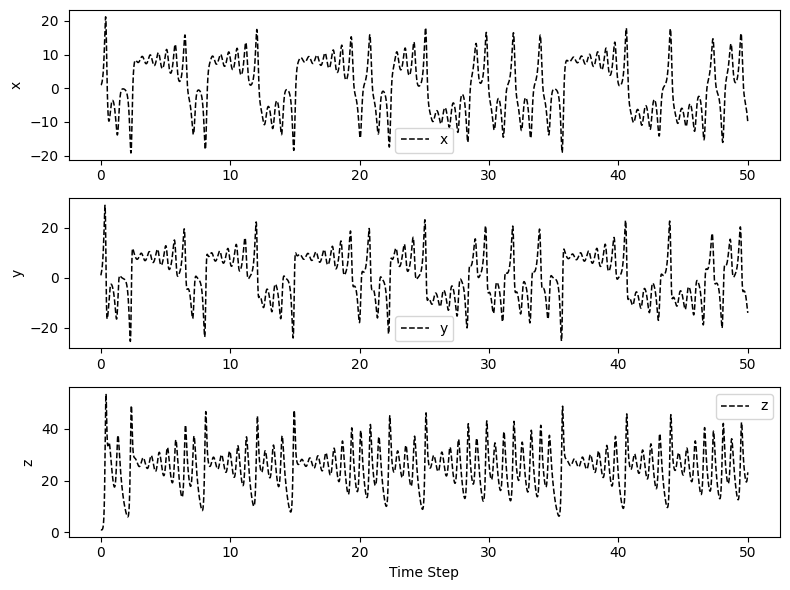

In [60]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

axs[0].plot(t, x, "k--", lw=1.1, label="x")
axs[0].set_ylabel("x"), axs[0].legend()

axs[1].plot(t, y, "k--", lw=1.1, label="y")
axs[1].set_ylabel("y"), axs[1].legend()

axs[2].plot(t, z, "k--", lw=1.1, label="z")
axs[2].set_ylabel("z"), axs[2].legend(), axs[2].set_xlabel("Time Step")

fig.tight_layout(), plt.show();

### Visualizing the Lorenz Attractor

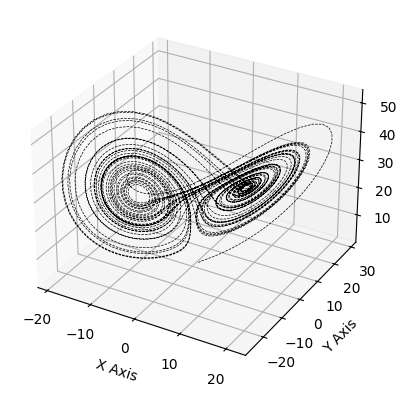

In [61]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x, y, z, "k--", lw=0.5)
ax.set_xlabel("X Axis"), ax.set_ylabel("Y Axis"), ax.set_zlabel("Z Axis")
plt.show()

### Demonstrating the Butterfly Effect

Integrate the Lorenz system with a slightly perturbed initial condition ...

In [62]:
t_a, x_a, y_a, z_a = lorenz(t0=0, x0=1 + 0.000_001, y0=1, z0=1, dt=0.01, 
                            sigma=10, rho=28, beta=8 / 3, iter_num=5_000)

... plotting the time evolution of the Lorenz system with a slightly perturbed initial
condition ...

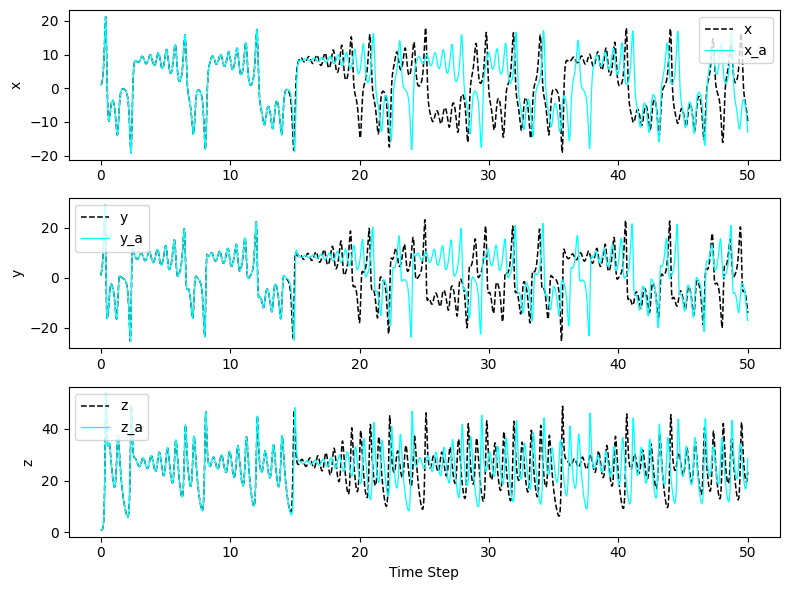

In [63]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

axs[0].plot(t, x, "k--", lw=1.1, label="x")
axs[0].plot(t_a, x_a, color="cyan", lw=0.9, label="x_a")
axs[0].set_ylabel("x"), axs[0].legend()

axs[1].plot(t, y, "k--", lw=1.1, label="y")
axs[1].plot(t_a, y_a, color="cyan", lw=0.9, label="y_a")
axs[1].set_ylabel("y"), axs[1].legend()

axs[2].plot(t, z, "k--", lw=1.1, label="z")
axs[2].plot(t_a, z_a, color="cyan", lw=0.9, label="z_a")
axs[2].set_ylabel("z"), axs[2].legend(), axs[2].set_xlabel("Time Step")

fig.tight_layout(), plt.show();

... and plot the Lorenz attractor with slightly perturbed initial conditions.

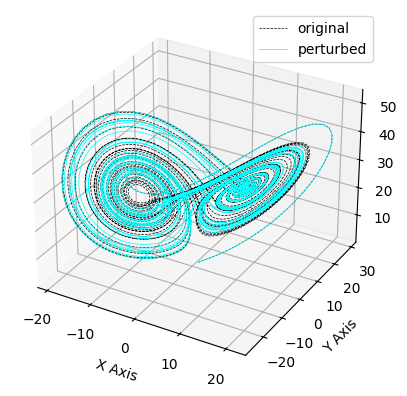

In [64]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x, y, z, "k--", lw=0.5, label="original")
ax.plot(x_a, y_a, z_a, color="cyan", lw=0.5, label="perturbed")
ax.set_xlabel("X Axis"), ax.set_ylabel("Y Axis"), ax.set_zlabel("Z Axis")
ax.legend(), plt.show();

## Implementing a Reservoir Computer

### Setting Up the Reservoir

Define the reservoir input ...

In [65]:
dim_system = 3
dim_reservoir = 300
edge_probability = 0.1

W_in = 2 * edge_probability * (np.random.rand(dim_reservoir, dim_system) - .5)

... define the reservoir state ...

In [66]:
reservoir_state = np.zeros(dim_reservoir)

... define the reservoir connections ...

In [67]:
import networkx as nx

scaling_factor = 1.1

graph = nx.gnp_random_graph(dim_reservoir, edge_probability)
graph = nx.to_numpy_array(graph)
A = 2 * (np.random.rand(dim_reservoir, dim_reservoir) - 0.5) * graph
eigenvalues, _ = np.linalg.eig(A)
A = A / np.absolute(np.amax(eigenvalues)) * scaling_factor

... and initialize the output weights ...

In [68]:
W_out = np.zeros((dim_system, dim_reservoir))

### Preparing the Training and Validation Data

In [69]:
iter_num = 10_000

t, x, y, z = lorenz(t0=0, x0=1, y0=1, z0=1, dt=0.01, 
                    sigma=10, rho=28, beta=8 / 3, iter_num=iter_num)
xyz = list(zip(x, y, z))

split_ratio = 0.50
split_idx = int(iter_num * split_ratio)
t_train, xyz_train = t[:split_idx], np.array(xyz[:split_idx])
t_val, xyz_val = t[split_idx:], np.array(xyz[split_idx:])

### Training the Reservoir Computer

Implement a numerically stable sigmoid function ...

In [70]:
def sigmoid(x):
    """Compute the sigmoid function for the input array."""
    return np.where(x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x)))

... train the reservoir computer ...

In [71]:
R = np.zeros((dim_reservoir, xyz_train.shape[0]))
for i in range(xyz_train.shape[0]):
    R[:, i] = reservoir_state
    reservoir_state = sigmoid(np.dot(A, reservoir_state) 
                              + np.dot(W_in, xyz_train[i]))

Rt = np.transpose(R)
regularization_factor = 0.0001
inverse_part = np.linalg.inv(np.dot(R, Rt) 
                             + regularization_factor * np.identity(R.shape[0]))
W_out = np.dot(np.dot(xyz_train.T, Rt), inverse_part)

... and predict the behavior of the Lorenz system with the trained reservoir computer.

In [72]:
step_to_be_predicted = len(xyz_val)

xyz_pred = np.zeros((step_to_be_predicted, dim_system))
for i in range(step_to_be_predicted):
    xyz_pred[i] = np.dot(W_out, reservoir_state)
    reservoir_state = sigmoid(np.dot(A, reservoir_state) 
                              + np.dot(W_in, xyz_pred[i]))

## Checking the Performance of the Reservoir Computer

Extract the validation dataset’s individual components and the predicted outcomes from the reservoir computer ...

In [73]:
x_val, y_val, z_val = xyz_val[:, 0], xyz_val[:, 1], xyz_val[:, 2]
x_pred, y_pred, z_pred = xyz_pred[:, 0], xyz_pred[:, 1], xyz_pred[:, 2]

... compare the trajectories ...

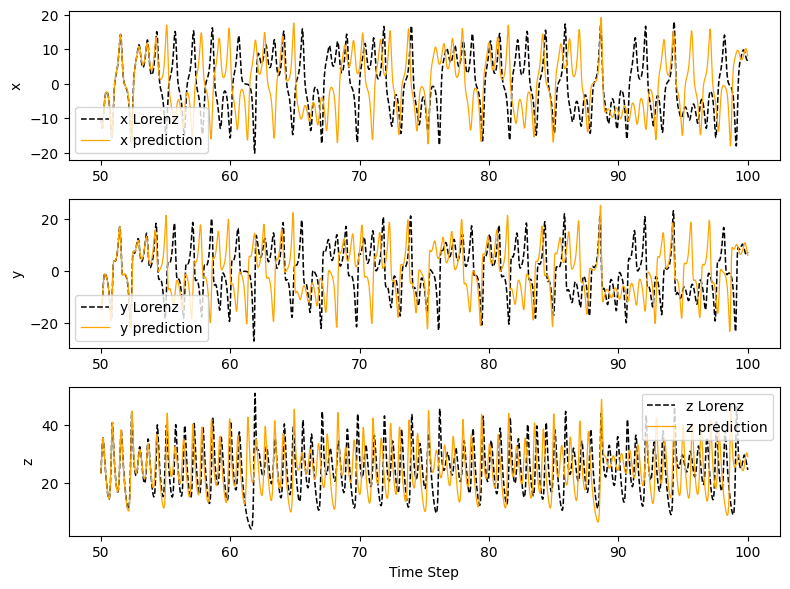

In [74]:
fig, axs = plt.subplots(3, 1, figsize=(8, 6))  

axs[0].plot(t_val, x_val, "k--",  lw=1.1, label="x Lorenz")
axs[0].plot(t_val, x_pred, color="orange", lw=0.9, label="x prediction")
axs[0].set_ylabel("x"), axs[0].legend()

axs[1].plot(t_val, y_val, "k--",  lw=1.1, label="y Lorenz")
axs[1].plot(t_val, y_pred, color="orange", lw=0.9, label="y prediction")
axs[1].set_ylabel("y"), axs[1].legend()

axs[2].plot(t_val, z_val, "k--",  lw=1.1, label="z Lorenz")
axs[2].plot(t_val, z_pred, color="orange", lw=0.9, label="z prediction")
axs[2].set_ylabel("z"), axs[2].legend(), axs[2].set_xlabel("Time Step")

fig.tight_layout(), plt.show();

... compare the Lorenz attractors ...

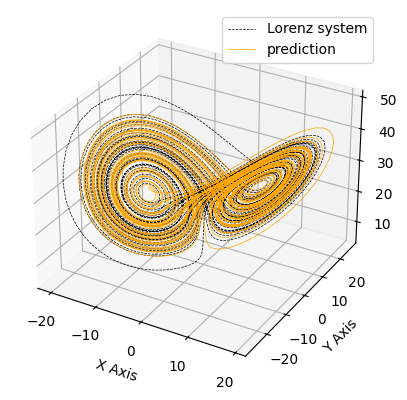

In [75]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.plot(x_val, y_val, z_val, "k--", lw=0.5, label="Lorenz system")
ax.plot(x_pred, y_pred, z_pred, lw=0.5, color="orange", label="prediction")
ax.set_xlabel("X Axis"), ax.set_ylabel("Y Axis"), ax.set_zlabel("Z Axis")
ax.legend(), plt.show();